# Exploring Foursquare's Explore Function

In this module we:
* Define some functions for exploring Foursquare venues
* Define some functions for displaying Folium maps
* Explore how LIMIT and RADIUS affect venues returned by Foursquare
    * Why do some calls with larger radius return fewer venues?
    * When is it more useful to call without a radius?
    * Which type of call gives the best venue density estimate?
* Explore how exploring for different categories affects Foursquare results
    * Does searching on a low depth category return high depth results?

## Imports

In [3]:
# General Use:
import pandas as pd
import numpy as np

# For Foursquare:
import requests
# Config should contain Foursquare credentials
import config
# In case config.py must be edited, this will reload them
import importlib
importlib.reload(config)

# For Folium:
import folium
import matplotlib.cm as cm
import matplotlib.colors
from folium.features import DivIcon

## Variables

In [4]:
CLIENT_ID = config.FOURSQUARE_CLIENT_ID
CLIENT_SECRET = config.FOURSQUARE_CLIENT_SECRET
ACCESS_TOKEN = config.FOURSQUARE_ACCESS_TOKEN
VERSION = '20180604'
LIMIT = 100
RADIUS = 500

## Foursquare Functions
TODO: rewrite to be more general (e.g. dataframe independent)

In [6]:
# Queries a location to find nearby venues, uses session variables CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT
def FoursquareExplore(latitude, longitude, radius):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    if results['response']=={}:
        if results['meta']['errorDetail']=='Quota exceeded':
            print('Foursquare quota exceeded, please try again later')
        else:
            print('No results returned')
        print(results)
    items = results['response']['groups'][0]['items']
    if len(items)>0:
        dataframe = pd.json_normalize(items)
        filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
        dataframe_filtered = dataframe.loc[:, filtered_columns]
        dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
        return dataframe_filtered
    else:
        return None

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(df_in, radius=500, extend=True):
    venues_df = pd.DataFrame(columns=['Postal Code','Venue Name','Venue Latitude','Venue Longitude','Venue Category','Radius'])
    for i, row in df_in.iterrows():
        # Get the neaby venues
        rad = radius
        df = FoursquareExplore(row['Latitude'],row['Longitude'],rad)
        print(row['Postal Code'])
        print(row['Postal Code'], f"radius {rad}", f"entries {df.shape[0] if not df is None else 0}")
        if extend:
            while (df is None or df.shape[0]<LIMIT/2) and rad<=max(radius,row['NN Distance [m]']/2):
                rad = rad+radius/2
                df = FoursquareExplore(row['Latitude'],row['Longitude'],rad)
                print(row['Postal Code'], f"radius {rad}", f"entries {df.shape[0] if not df is None else 0}")
        # Shorten the dataframe
        if not df is None:
            df_add = pd.DataFrame([[row['Postal Code'],r['name'],r['lat'],r['lng'],get_category_type(r),rad] for _, r in df.iterrows()], columns=venues_df.columns)
            venues_df = venues_df.append(df_add,ignore_index=True)
    return(venues_df)

def resumableGetNearbyVenues(df_in,df_venues=None,radius=500,extend=True):
    # Can be called with partial results in df_venues, and will resume populating it until another quota error from Foursquare
    # df_venues is populated only after satisfying query conditions (may need multiple calls if extend=True)
    # Need to deal with indexing - .loc uses dataframe indexes which are not necessarily zero-based 1-increment
    # TODO: Change selection method to evaluate indices only when they are not found in df_venues, this could also handle change of order
    if df_venues is None or df_venues.shape[0]==0:
        df_venues = pd.DataFrame(columns=['Postal Code','Venue Name','Venue Latitude','Venue Longitude','Venue Category','Radius'])
        current_index = 0
    else:
        last_postal_code = df_venues['Postal Code'][df_venues.shape[0]-1]
        current_index = np.asarray(df_in['Postal Code']==last_postal_code).nonzero()[0][0]+1
        # TODO: handle case where a complete df_venues is provided, though this should not occur because isComplete is returned
    
    isComplete = current_index == (df_in.shape[0])
    for index in range(current_index,df_in.shape[0]):
        try:
            df_add = getNearbyVenues(df_in.iloc[[index],:],radius=radius,extend=extend)
            df_venues = df_venues.append(df_add, ignore_index=True)
            isComplete = index == (df_in.shape[0]-1)
        except KeyError:
            isComplete = False
            print('Error encountered in venue lookup')
            break

    return isComplete, df_venues


In [ ]:
isComplete, df_venues = resumableGetNearbyVenues(df_final, None, radius=RADIUS, extend=True)
print('Venue lookup completed successfully' if isComplete else 'Venue lookup interrupted')
display(df_venues.head())

if not isComplete:
    isComplete, df_venues = resumableGetNearbyVenues(df_final, df_venues, radius=RADIUS, extend=True)
    print('Venue lookup completed successfully' if isComplete else 'Venue lookup interrupted')
    display(df_venues)
else:
    print('Venue lookup is already finished')

In Capstone.ipynb we found several postal codes where the number of venues returned decreased when radius increased:
* M4B
    M4B radius 500 entries 15
    M4B radius 750.0 entries 23
    M4B radius 1000.0 entries 20
* M3N
    M3N radius 500 entries 19
    M3N radius 750.0 entries 28
    M3N radius 1000.0 entries 29
    M3N radius 1250.0 entries 24
    M3N radius 1500.0 entries 22
* M2P
    M2P radius 500 entries 4
    M2P radius 750.0 entries 20
    M2P radius 1000.0 entries 18
* M1T
    M1T radius 500 entries 16
    M1T radius 750.0 entries 36
    M1T radius 1000.0 entries 40
    M1T radius 1250.0 entries 47
    M1T radius 1500.0 entries 44
* M8V
    M8V radius 500 entries 5
    M8V radius 750.0 entries 4
    M8V radius 1000.0 entries 37
    M8V radius 1250.0 entries 49
    M8V radius 1500.0 entries 43
* M8W
    M8W radius 500 entries 4
    M8W radius 750.0 entries 8
    M8W radius 1000.0 entries 27
    M8W radius 1250.0 entries 40
    M8W radius 1500.0 entries 37
* M9W
    M9W radius 500 entries 7
    M9W radius 750.0 entries 9
    M9W radius 1000.0 entries 13
    M9W radius 1250.0 entries 31
    M9W radius 1500.0 entries 36
    M9W radius 1750.0 entries 35

In [64]:
fsas = ['M4B','M3N','M2P','M1T','M8V','M8W','M9W']
radii = [[500, 750, 1000],[500,750,1000,1250,1500],[500,750,1000],[500,750,1000,1250,1500],[500,750,1000,1250,1500],[500,750,1000,1250,1500],[500,750,1000,1250,1500,1750]]

In [7]:
df = pd.DataFrame(columns=['Postal Code','Latitude','Longitude'])
df['Postal Code'] = fsas
df

,Postal Code,Latitude,Longitude
0,M4B,NaN,NaN
1,M3N,NaN,NaN
2,M2P,NaN,NaN
3,M1T,NaN,NaN
4,M8V,NaN,NaN
5,M8W,NaN,NaN
6,M9W,NaN,NaN


In [9]:
from geopy.geocoders import Here
gc = Here(apikey=config.HERE_APIKEY)

In [10]:
for i, row in df.iterrows():
    g = gc.geocode(f"{row['Postal Code']}, Ontario")
    if g!=None:
        df.loc[i,'Latitude'] = g[1][0]
        df.loc[i,'Longitude'] = g[1][1]
    else:
        print(f"Geocoding failed for Postal Code: {row['Postal Code']}, Borough: {row['Borough']}, Neighborhoods: {row['Neighbourhood']}")

In [11]:
df

,Postal Code,Latitude,Longitude
0,M4B,43.7072,-79.3119
1,M3N,43.7548,-79.5196
2,M2P,43.7478,-79.4003
3,M1T,43.7849,-79.2972
4,M8V,43.6099,-79.4981
5,M8W,43.6012,-79.5388
6,M9W,43.7117,-79.5794


In [21]:
df_radii = pd.DataFrame(columns=['Postal Code','Venue Name','Venue Latitude','Venue Longitude','Venue Category','Radius'])
for i, row in df.iterrows():
    for radius in radii[i]:
        df_radii = df_radii.append(getNearbyVenues(df.iloc[[i],:], radius=radius, extend=False), ignore_index=True)
df_radii

M4B
M4B radius 500 entries 14
M4B
M4B radius 750 entries 22
M4B
M4B radius 1000 entries 20
M3N
M3N radius 500 entries 19
M3N
M3N radius 750 entries 28
M3N
M3N radius 1000 entries 28
M3N
M3N radius 1250 entries 26
M3N
M3N radius 1500 entries 26
M2P
M2P radius 500 entries 4
M2P
M2P radius 750 entries 17
M2P
M2P radius 1000 entries 21
M1T
M1T radius 500 entries 15
M1T
M1T radius 750 entries 34
M1T
M1T radius 1000 entries 38
M1T
M1T radius 1250 entries 47
M1T
M1T radius 1500 entries 44
M8V
M8V radius 500 entries 5
M8V
M8V radius 750 entries 4
M8V
M8V radius 1000 entries 35
M8V
M8V radius 1250 entries 44
M8V
M8V radius 1500 entries 42
M8W
M8W radius 500 entries 4
M8W
M8W radius 750 entries 8
M8W
M8W radius 1000 entries 27
M8W
M8W radius 1250 entries 37
M8W
M8W radius 1500 entries 35
M9W
M9W radius 500 entries 8
M9W
M9W radius 750 entries 9
M9W
M9W radius 1000 entries 15
M9W
M9W radius 1250 entries 30
M9W
M9W radius 1500 entries 33
M9W
M9W radius 1750 entries 35


,Postal Code,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Radius
0,M4B,Jawny Bakers,43.705783,-79.312913,Gastropub,500
1,M4B,Toronto Climbing Academy,43.709362,-79.315006,Rock Climbing Spot,500
2,M4B,East York Gymnastics,43.710654,-79.309279,Gym / Fitness Center,500
3,M4B,Shoppers Drug Mart,43.705933,-79.312825,Pharmacy,500
4,M4B,TD Canada Trust,43.705740,-79.312270,Bank,500
...,...,...,...,...,...,...
769,M9W,Pizzaville,43.719817,-79.570029,Pizza Place,1750
770,M9W,Sunnydale Outdoor Rink,43.724608,-79.578065,Skating Rink,1750
771,M9W,Hakka Cottage,43.713007,-79.559973,Halal Restaurant,1750
772,M9W,Saand Rexdale,43.705072,-79.598725,Drugstore,1750


In [80]:
index = 0

map_toronto = folium.Map(location=[*df.loc[df['Postal Code']==fsas[index],['Latitude','Longitude']].values[0]], zoom_start=14) # generate map centred around the center of postal codes
colors = [matplotlib.colors.to_hex(cm.hsv(x/(len(np.unique(radii[index]))))) for x in range(len(np.unique(radii[index])))]
colors = ['red','yellow','blue']
for i, row in df_radii.loc[df_radii['Postal Code']==fsas[index],:].iterrows():
    folium.CircleMarker(
        [row['Venue Latitude'], row['Venue Longitude']],
        radius=5,
        color='',
        popup=row['Postal Code'],
        tooltip=f"{row['Venue Name']}, {row['Venue Category']}",
        fill = True,
        fill_color = colors[np.where(np.array(radii[index])==row['Radius'])[0][0]],
        fill_opacity = 0.3
    ).add_to(map_toronto)
for radius in radii[index]:
    folium.Circle(
        [*df.loc[df['Postal Code']==fsas[index],['Latitude','Longitude']].values[0]],
        color='gray',
        tooltip=f"{radius} m",
        radius=radius,
        fill = False
    ).add_to(map_toronto)
    
map_toronto

https://stackoverflow.com/questions/57943687/showing-two-folium-maps-side-by-side

from IPython.core.display import display, HTML

htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(map_toronto.get_root().render().replace('"', '&quot;'),500,500,
                   map_nyc.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

You may need to format the text in the CircleMaker to not include single tick characters or other special characters to embed it in the iframe properly

nyc_df= nyc_df(to_replace=r'\'', value="", regex=True)


In [68]:
np.where(np.array(radii[index])==500)[0][0]

0

In [ ]:
#centroidlatlon = [df_final['Latitude'].mean(), df_final['Longitude'].mean()]
map_toronto = folium.Map(location=centroidlatlon, zoom_start=11) # generate map centred around the center of postal codes

cluster_names = ['0: Downtown',
                 '1: Suburban Balanced',
                 '2: Urban Food and Nightlife',
                 '3: Suburban Outdoors Focused',
                 '4: Mid-Urban Entertainment and Shopping',
                 '5: Suburban Food-Focused',
                 '6: Suburban Shop-Focused',
                 '7: High-Density Housing',
                 '8: Collegetown']

feature_groups = [x for x in range(len(cluster_names))]
for k in range(len(feature_groups)):
    feature_groups[k] = folium.FeatureGroup(name=cluster_names[k])

colors = [matplotlib.colors.to_hex(cm.hsv(x/(len(np.unique(clusters))))) for x in range(len(np.unique(clusters)))]
for (cluster, label) in zip(clusters,labels):
    folium.CircleMarker(
        (df_final.loc[df_final['Postal Code']==label,'Latitude'], df_final.loc[df_final['Postal Code']==label,'Longitude']),
        radius=7,
        color=colors[cluster],
        fill = True,
        fill_color = colors[cluster],
        fill_opacity = 0.6,
        popup=f"{label}, Cluster {cluster}",
        tooltip=f"{label}, Cluster {cluster}"
    ).add_to(feature_groups[cluster])
    folium.map.Marker(
        (df_final.loc[df_final['Postal Code']==label,'Latitude'], df_final.loc[df_final['Postal Code']==label,'Longitude']),
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(4,10),
            html='<div style="font-size: 10pt">%s</div>' % str(cluster),
        )
    ).add_to(feature_groups[cluster])

for k in range(len(feature_groups)):
    map_toronto.add_child(feature_groups[k])

map_toronto.add_child(folium.map.LayerControl(position='bottomright',collapsed=False))
    
map_toronto

We can now get nearby venues for each postal code.  The Radius entry is the radius (in meters) that is required for the Foursquare API to return at least LIMIT/2 (50) venues.  Radius is increased in increments of half the input radius until LIMIT/2 venues are returned if the extend parameter is True.

In [48]:
isComplete, df_venues = resumableGetNearbyVenues(df_final, None, radius=RADIUS, extend=True)
print('Venue lookup completed successfully' if isComplete else 'Venue lookup interrupted')
display(df_venues.head())

M3A
M3A radius 500 entries 2
M3A radius 750.0 entries 5
M3A radius 1000.0 entries 24
M3A radius 1250.0 entries 26
M4A
M4A radius 500 entries 2
M4A radius 750.0 entries 10
M4A radius 1000.0 entries 13
M4A radius 1250.0 entries 34
M5A
M5A radius 500 entries 21
M5A radius 750.0 entries 89
M6A
M6A radius 500 entries 51
M9A
M9A radius 500 entries 8
M9A radius 750.0 entries 15
M9A radius 1000.0 entries 15
M1B
M1B radius 500 entries 1
M1B radius 750.0 entries 7
M1B radius 1000.0 entries 5
M1B radius 1250.0 entries 26
M1B radius 1500.0 entries 35
M3B
M3B radius 500 entries 7
M3B radius 750.0 entries 28
M3B radius 1000.0 entries 30
M4B
M4B radius 500 entries 15
M4B radius 750.0 entries 23
M4B radius 1000.0 entries 20
M5B
M5B radius 500 entries 100
M6B
M6B radius 500 entries 13
M6B radius 750.0 entries 22
M6B radius 1000.0 entries 33
M9B
M9B radius 500 entries 5
M9B radius 750.0 entries 9
M9B radius 1000.0 entries 17
M1C
M1C radius 500 entries 3
M1C radius 750.0 entries 5
M1C radius 1000.0 entri

,Postal Code,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Radius
0,M3A,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,1250
1,M3A,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course,1250
2,M3A,Tim Hortons,43.760668,-79.326368,Café,1250
3,M3A,Brookbanks Park,43.751976,-79.332140,Park,1250
4,M3A,Bruno's valu-mart,43.746143,-79.324630,Grocery Store,1250


If the lookup fails due to quotas (or presumably timeout), the following cell can be run multiple times until successful completion (e.g. on multiple days should operation be interrupted due to exceeding quotas).

In [49]:
if not isComplete:
    isComplete, df_venues = resumableGetNearbyVenues(df_final, df_venues, radius=RADIUS, extend=True)
    print('Venue lookup completed successfully' if isComplete else 'Venue lookup interrupted')
    display(df_venues)
else:
    print('Venue lookup is already finished')

Venue lookup is already finished


Let's make sure we have some features for every location:

In [50]:
missing_postal_codes = list(np.setdiff1d(df_final['Postal Code'],df_venues['Postal Code']))
print(f"There are {len(missing_postal_codes)} postal codes with no venues: {missing_postal_codes}")
print(f"There are {len(df_venues['Venue Category'].unique())} unique categories among {df_venues.shape[0]} venues (ratio of 1 to {df_venues.shape[0]/len(df_venues['Venue Category'].unique()):.1f}).")

There are 0 postal codes with no venues: []
There are 337 unique categories among 4175 venues (ratio of 1 to 12.4).


Let's see the distribution of number of venues found in each postal code:

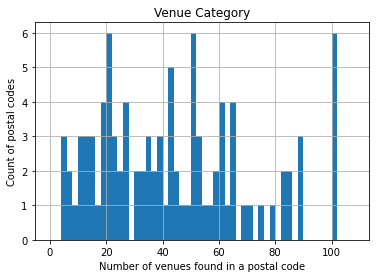

In [51]:
df_venue_counts = df_venues[['Postal Code','Venue Category']].groupby('Postal Code').count()
df_venue_counts.hist(bins=np.arange(0,110,2))
plt.xlabel('Number of venues found in a postal code')
plt.ylabel('Count of postal codes');

And the distribution of frequency of venue type across all of Toronto:

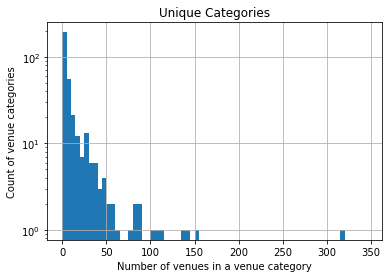

In [52]:
df_category_counts = df_venues[['Postal Code','Venue Category']].groupby('Venue Category').count()
df_category_counts.rename(columns={'Postal Code':'Unique Categories'},inplace=True)
df_category_counts.hist(bins=np.arange(0,350,5),log=True)
plt.xlabel('Number of venues in a venue category')
plt.ylabel('Count of venue categories');

Now it seems there is a [heirarchy of categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/) and we might do well to restrict ourselves to higher level categories.  Let's get the category data structure:

In [53]:
try:
    categories_list = requests.get(f"https://api.foursquare.com/v2/venues/categories?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}").json()
    categories_list = categories_list['response']['categories']
    print('Categories retrieved')
except KeyError:
    print('There was an error getting categories from Foursquare')

Categories retrieved


In [54]:
def findParentCategories(categories_list,categories_dict={},parents=[]):
    # Recursively explore categories_list, and modify categories_dict, where the keys are the categroies and values are lists of parents, highest first. 
    for c in categories_list:
        categories_dict[c['name']] = parents
        if len(c['categories'])==0: # Leaf condition
            categories_dict[c['name']] = parents
        else: # Branch condition
            findParentCategories(c['categories'],categories_dict,[*parents, c['name']])

def getCategoriesByDepth(categories_dict,depth=0):
    # Returns a dict of all categories at the given depth (with parent list for values)
    ret = {}
    for key, val in categories_dict.items():
        if len(val)==depth:
            ret[key] = val
    return ret

def getCategoryDepth(categories_dict,category):
    # Returns the integer dpeth of category in categories_dict
    return len(categories_dict['category'])

In [55]:
categories_dict = {}
findParentCategories(categories_list,categories_dict)
print(f"There are {len(categories_dict)} unique category labels.")

There are 970 unique category labels.


And we can examine how many labels are at each level of the hierarchy:

In [56]:
category_count = []
categories_depth_list = []
while sum(category_count)<len(categories_dict):
    categories_depth_list.append(getCategoriesByDepth(categories_dict,len(category_count)))
    category_count.append(len(categories_depth_list[-1]))
    print(f"There are {category_count[-1]} categories at depth {len(category_count)-1}.")

There are 10 categories at depth 0.
There are 470 categories at depth 1.
There are 382 categories at depth 2.
There are 94 categories at depth 3.
There are 14 categories at depth 4.


This can quickly find the sum of branch and leaf categories at each depth in our data:

In [57]:
df_venues['Category Parents'] = [categories_dict[row['Venue Category']] for _, row in df_venues.iterrows()]
df_venues['Category Depth'] = df_venues['Category Parents'].apply(len)
display(df_venues.head(3))

for k in np.sort(df_venues['Category Depth'].unique()):
    colname = f"Venue Category, Depth {k}"
    print(f"At depth {k} there are {sum(df_venues['Category Depth']==k)} venue category entries.")

,Postal Code,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Radius,Category Parents,Category Depth
0,M3A,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,1250,[Food],1
1,M3A,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course,1250,"[Outdoors & Recreation, Athletics & Sports]",2
2,M3A,Tim Hortons,43.760668,-79.326368,Café,1250,[Food],1


At depth 0 there are 4 venue category entries.
At depth 1 there are 3107 venue category entries.
At depth 2 there are 908 venue category entries.
At depth 3 there are 155 venue category entries.
At depth 4 there are 1 venue category entries.


Alternatively, we can examine explicitly how many labels are leaf or branch nodes for all potential categories:

In [58]:
leaf_list = []
node_list = []
for k in range(max(df_venues['Category Depth'])+1):
    leaf_list.append([])
    node_list.append([])

for key, val in categories_dict.items(): # Go through the dict; if a key appears in a value, it is a branch, if it never appears in a value (as a parent), it is a leaf
    node = False
    for k, v in categories_dict.items():
        if key==k:
            pass
        elif key in v: # Key appears as a parent
            node_list[len(val)].append(key)
            node=True
            break
    if not node: # Key did not appear as a parent - it is a leaf
        leaf_list[len(val)].append(key)

for k in range(len(leaf_list)):
    print(f"At depth {k} there are {len(node_list[k])} branches and {len(leaf_list[k])} leaves.")

At depth 0 there are 10 branches and 0 leaves.
At depth 1 there are 53 branches and 417 leaves.
At depth 2 there are 10 branches and 372 leaves.
At depth 3 there are 2 branches and 92 leaves.
At depth 4 there are 0 branches and 14 leaves.


And then discover whether the Toronto venue data categories occur at branch or leaf nodes:

In [59]:
leaf_toronto = [[] for k in range(len(leaf_list))]
node_toronto = [[] for k in range(len(node_list))]

for cat in df_venues['Venue Category']:
    for k in range(len(leaf_list)):
        if cat in leaf_list[k]:
            leaf_toronto[k].append(cat)
        if cat in node_list[k]:
            node_toronto[k].append(cat)

for k in range(len(leaf_toronto)):
    print(f"At depth {k} there are {len(node_toronto[k])} categories that are branches and {len(leaf_toronto[k])} categories that are leaves.")

At depth 0 there are 4 categories that are branches and 0 categories that are leaves.
At depth 1 there are 645 categories that are branches and 2462 categories that are leaves.
At depth 2 there are 228 categories that are branches and 680 categories that are leaves.
At depth 3 there are 2 categories that are branches and 153 categories that are leaves.
At depth 4 there are 0 categories that are branches and 1 categories that are leaves.


### Venue Feature Creation

We can create one-hots both for leaf and node categories and to assign more weight in the clustering to lower depth nodes (to emphasize matching broader categories first, but this may get needlessly complex.  We can generate the additional one-hot dataframes just in case, but then continue with the simpler analysis first.

Note that this could be done by limiting different parent categories to different depths of children, but that is too complex for now.

Note also that it would be reasonable to compact some venues (like zoo exhibits) into one entry in order to not overemphasize certain venues (like zoos), but this is also a bit beyond the current complexity level.

In [60]:
for k in np.sort(df_venues['Category Depth'].unique()):
    df_venues[[f"Venue Category, Depth {k}"]] = [row['Venue Category'] if row['Category Depth']<=k else row['Category Parents'][k] for _,row in df_venues.iterrows()]
df_venues.head()

,Postal Code,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Radius,Category Parents,Category Depth,"Venue Category, Depth 0","Venue Category, Depth 1","Venue Category, Depth 2","Venue Category, Depth 3","Venue Category, Depth 4"
0,M3A,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,1250,[Food],1,Food,Caribbean Restaurant,Caribbean Restaurant,Caribbean Restaurant,Caribbean Restaurant
1,M3A,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course,1250,"[Outdoors & Recreation, Athletics & Sports]",2,Outdoors & Recreation,Athletics & Sports,Golf Course,Golf Course,Golf Course
2,M3A,Tim Hortons,43.760668,-79.326368,Café,1250,[Food],1,Food,Café,Café,Café,Café
3,M3A,Brookbanks Park,43.751976,-79.332140,Park,1250,[Outdoors & Recreation],1,Outdoors & Recreation,Park,Park,Park,Park
4,M3A,Bruno's valu-mart,43.746143,-79.324630,Grocery Store,1250,"[Shop & Service, Food & Drink Shop]",2,Shop & Service,Food & Drink Shop,Grocery Store,Grocery Store,Grocery Store


It may be useful to know how many categories we have to deal with at each depth:

In [61]:
for k in np.sort(df_venues['Category Depth'].unique()):
    colname = f"Venue Category, Depth {k}"
    print(f"There are {len(df_venues[colname].unique())} unique categories limited to depth {k}")

There are 9 unique categories limited to depth 0
There are 226 unique categories limited to depth 1
There are 316 unique categories limited to depth 2
There are 336 unique categories limited to depth 3
There are 337 unique categories limited to depth 4


From all this we expect that most the optimal category depth will be 1 or 2; depth 0 is quite general, while depth above 2 becomes too specific and adds little additional information (no information in the case of depth 4).

Note that the columns 'Venue Category' and 'Venue Category, Depth 4' are equivalent.

In [62]:
all(df_venues['Venue Category']==df_venues['Venue Category, Depth 4'])

True

#### Create a venue vector for each neighborhood

In [63]:
def makeOneHot(df,colname,keycolname):
    # Returns (onehot of df[colname] with first column df[keycolname],
    #          df with leading column df[keycolname].unique() and rows the normalized venue frequency vector and columns the venue category
    onehot = pd.get_dummies(df[[colname]], prefix="", prefix_sep="")
    onehot[keycolname] = df[keycolname]
    onehot = onehot[[onehot.columns[-1]] + list(onehot.columns[:-1])]
    grouped = onehot.groupby(keycolname).mean().reset_index()
    return onehot, grouped

In [64]:
# Basic one-hot encoding
toronto_onehot, toronto_grouped = makeOneHot(df_venues,'Venue Category','Postal Code')

# Create columns to hold venues limited to a given depth
toronto_onehot_0, toronto_grouped_0 = makeOneHot(df_venues,'Venue Category, Depth 0','Postal Code')
toronto_onehot_1, toronto_grouped_1 = makeOneHot(df_venues,'Venue Category, Depth 1','Postal Code')
toronto_onehot_2, toronto_grouped_2 = makeOneHot(df_venues,'Venue Category, Depth 2','Postal Code')
toronto_onehot_3, toronto_grouped_3 = makeOneHot(df_venues,'Venue Category, Depth 3','Postal Code')
toronto_onehot_4, toronto_grouped_4 = makeOneHot(df_venues,'Venue Category, Depth 4','Postal Code')

print()
print('Full Depth category coding:')
print()
display(toronto_onehot.head())
print(f"Shape of Full Depth category coding: {toronto_onehot.shape}")
print()
display(toronto_grouped.head())
print(f"Shape of Full Depth category coding, grouped by Postal Code: {toronto_grouped.shape}")
print()

print()
print('Depth 0 category coding:')
print()
display(toronto_onehot_0.head())
print(f"Shape of Depth 0 category coding: {toronto_onehot_0.shape}")
print()
display(toronto_grouped_0.head())
print(f"Shape of Depth 0 category coding, grouped by Postal Code: {toronto_grouped_0.shape}")


Full Depth category coding:



,Postal Code,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Shape of Full Depth category coding: (4175, 338)



,Postal Code,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.342857
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Shape of Full Depth category coding, grouped by Postal Code: (96, 338)


Depth 0 category coding:



,Postal Code,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M3A,0,0,1,0,0,0,0,0,0
1,M3A,0,0,0,0,1,0,0,0,0
2,M3A,0,0,1,0,0,0,0,0,0
3,M3A,0,0,0,0,1,0,0,0,0
4,M3A,0,0,0,0,0,0,0,1,0


Shape of Depth 0 category coding: (4175, 10)



,Postal Code,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,M1B,0.342857,0.0,0.257143,0.000000,0.057143,0.000000,0.0,0.314286,0.028571
1,M1C,0.000000,0.0,0.307692,0.000000,0.461538,0.000000,0.0,0.153846,0.076923
2,M1E,0.000000,0.0,0.411765,0.039216,0.117647,0.019608,0.0,0.333333,0.078431
3,M1G,0.000000,0.0,0.666667,0.000000,0.111111,0.000000,0.0,0.222222,0.000000
4,M1H,0.000000,0.0,0.636364,0.045455,0.045455,0.000000,0.0,0.227273,0.045455


Shape of Depth 0 category coding, grouped by Postal Code: (96, 10)


It may be interesting to examine the venues occurring at highest frequency in each postal code.  We do so below, but note that this is not used in feature generation in favor of the grouped onehot vectors.  Using features created only from the highest frequency venue categories would be an interesting approach to try (some other time).

In [65]:
def printNeighborhoodVenueFrequency(df_tmp, key_col_name='Postal Code', num_top_venues=5):
    for hood in df_tmp[key_col_name]:
        neighborhoods_str = ''
        for n in df_final.loc[df_final['Postal Code']==hood,'Neighbourhood']:
            neighborhoods_str += n
        print("----"+hood+": "+neighborhoods_str+"----")
        temp = df_tmp[df_tmp[key_col_name] == hood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
        print('\n')

In [66]:
printNeighborhoodVenueFrequency(toronto_grouped,'Postal Code',5)

----M1B: Malvern, Rouge----
                     venue  freq
0              Zoo Exhibit  0.34
1     Fast Food Restaurant  0.06
2                    Trail  0.06
3  Health & Beauty Service  0.03
4              Bus Station  0.03


----M1C: Rouge Hill, Port Union, Highland Creek----
            venue  freq
0            Park  0.23
1           Hotel  0.08
2           Diner  0.08
3  Breakfast Spot  0.08
4    Neighborhood  0.08


----M1E: Guildwood, Morningside, West Hill----
            venue  freq
0      Restaurant  0.08
1     Pizza Place  0.08
2            Park  0.06
3  Breakfast Spot  0.06
4            Bank  0.04


----M1G: Woburn----
                   venue  freq
0            Pizza Place  0.11
1      Indian Restaurant  0.11
2                   Park  0.11
3   Fast Food Restaurant  0.11
4  Vietnamese Restaurant  0.06


----M1H: Cedarbrae----
               venue  freq
0  Indian Restaurant  0.18
1        Coffee Shop  0.09
2           Bus Line  0.05
3        Music Store  0.05
4       Burger 

In [67]:
printNeighborhoodVenueFrequency(toronto_grouped_0,'Postal Code',5)

----M1B: Malvern, Rouge----
                   venue  freq
0   Arts & Entertainment  0.34
1         Shop & Service  0.31
2                   Food  0.26
3  Outdoors & Recreation  0.06
4     Travel & Transport  0.03


----M1C: Rouge Hill, Port Union, Highland Creek----
                   venue  freq
0  Outdoors & Recreation  0.46
1                   Food  0.31
2         Shop & Service  0.15
3     Travel & Transport  0.08
4   Arts & Entertainment  0.00


----M1E: Guildwood, Morningside, West Hill----
                   venue  freq
0                   Food  0.41
1         Shop & Service  0.33
2  Outdoors & Recreation  0.12
3     Travel & Transport  0.08
4         Nightlife Spot  0.04


----M1G: Woburn----
                   venue  freq
0                   Food  0.67
1         Shop & Service  0.22
2  Outdoors & Recreation  0.11
3   Arts & Entertainment  0.00
4   College & University  0.00


----M1H: Cedarbrae----
                   venue  freq
0                   Food  0.64
1         Shop &

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [69]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Zoo Exhibit,Fast Food Restaurant,Trail,Paper / Office Supplies Store,Coffee Shop,Restaurant,Chinese Restaurant,Sandwich Place,Caribbean Restaurant,Grocery Store
1,M1C,Park,Hotel,Diner,Bank,Neighborhood,Gym,Gym / Fitness Center,Italian Restaurant,Burger Joint,Pharmacy
2,M1E,Pizza Place,Restaurant,Park,Breakfast Spot,Hotel,Fast Food Restaurant,Pharmacy,Bank,Coffee Shop,Liquor Store
3,M1G,Indian Restaurant,Pizza Place,Fast Food Restaurant,Park,Thrift / Vintage Store,Chinese Restaurant,Sandwich Place,Juice Bar,Discount Store,Supermarket
4,M1H,Indian Restaurant,Coffee Shop,Athletics & Sports,Hakka Restaurant,German Restaurant,Thai Restaurant,Gas Station,Bus Line,Bank,Bakery


Returning to feature generation, it might be useful to include the overall areal density of venues as a feature.  This can be done using the radius that was required to get the target number of venues returned when we listed the venues in each postal code.  This method is imperfect because of the results massaging done by Foursquare, but is the best we can do with that data source.

Venue density varies from 0.849 to 127.324 with mean 23.476 and standard deviation 29.736


,Postal Code,Venue Radius,Venue Count,Venue Density,Log10 (Venue Density)
0,M1B,1500.0,35,4.951487,0.694736
1,M1C,1500.0,13,1.839124,0.264611
2,M1E,1500.0,51,7.215024,0.858238
3,M1G,1000.0,18,5.729578,0.758123
4,M1H,1000.0,22,7.002817,0.845273


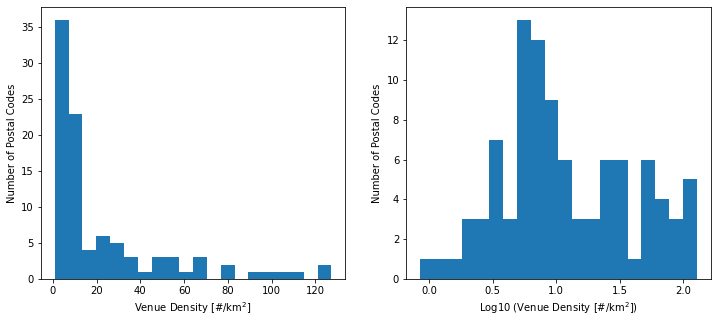

In [70]:
df_venue_density = df_venues[['Postal Code','Radius']].groupby('Postal Code').mean(numeric_only=False).reset_index().rename(columns={'Radius':'Venue Radius'})
df_venue_density = df_venue_density.merge(df_venues[['Postal Code','Radius']].groupby('Postal Code').count().reset_index().rename(columns={'Radius':'Venue Count'}),on='Postal Code')
df_venue_density['Venue Density'] = df_venue_density['Venue Count']/(np.pi*(df_venue_density['Venue Radius']/1000)**2)
df_venue_density['Log10 (Venue Density)'] = df_venue_density['Venue Density'].apply(np.log10)

print(f"Venue density varies from {min(df_venue_density['Venue Density']):.3f} to {max(df_venue_density['Venue Density']):.3f} with mean {np.mean(df_venue_density['Venue Density']):.3f} and standard deviation {np.std(df_venue_density['Venue Density']):.3f}")

display(df_venue_density.head())

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
ax.hist(x=df_venue_density['Venue Density'],bins=20,log=False)
ax.set_xlabel('Venue Density [#/km$^2$]')
ax.set_ylabel('Number of Postal Codes')
ax = axs[1]
ax.hist(x=df_venue_density['Log10 (Venue Density)'],bins=20,log=False)
ax.set_xlabel('Log10 (Venue Density [#/km$^2$])')
ax.set_ylabel('Number of Postal Codes');

The distribution of the logarithm of venue density looks more normal and therefore is expected to be better suited as a feature for clustering, so we will use that below.

Here we construct a list of inputs to our clustering algorithm, with the most relevant entry being various feature sets it will be interesting to fit to, including:
* Venue data only
* Census data and venue density data only
* Combined venue and census/venue density data
* Alternative preprocessing (scaling)

Note that giving different scale factors to various features might result in improved fits - this might be worth exploring in a future work.

In [634]:


#centroidlatlon = [df_final['Latitude'].mean(), df_final['Longitude'].mean()]
map_toronto = folium.Map(location=centroidlatlon, zoom_start=11) # generate map centred around the center of postal codes

cluster_names = ['0: Downtown',
                 '1: Suburban Balanced',
                 '2: Urban Food and Nightlife',
                 '3: Suburban Outdoors Focused',
                 '4: Mid-Urban Entertainment and Shopping',
                 '5: Suburban Food-Focused',
                 '6: Suburban Shop-Focused',
                 '7: High-Density Housing',
                 '8: Collegetown']

feature_groups = [x for x in range(len(cluster_names))]
for k in range(len(feature_groups)):
    feature_groups[k] = folium.FeatureGroup(name=cluster_names[k])

colors = [matplotlib.colors.to_hex(cm.hsv(x/(len(np.unique(clusters))))) for x in range(len(np.unique(clusters)))]
for (cluster, label) in zip(clusters,labels):
    folium.CircleMarker(
        (df_final.loc[df_final['Postal Code']==label,'Latitude'], df_final.loc[df_final['Postal Code']==label,'Longitude']),
        radius=7,
        color=colors[cluster],
        fill = True,
        fill_color = colors[cluster],
        fill_opacity = 0.6,
        popup=f"{label}, Cluster {cluster}",
        tooltip=f"{label}, Cluster {cluster}"
    ).add_to(feature_groups[cluster])
    folium.map.Marker(
        (df_final.loc[df_final['Postal Code']==label,'Latitude'], df_final.loc[df_final['Postal Code']==label,'Longitude']),
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(4,10),
            html='<div style="font-size: 10pt">%s</div>' % str(cluster),
        )
    ).add_to(feature_groups[cluster])

for k in range(len(feature_groups)):
    map_toronto.add_child(feature_groups[k])

map_toronto.add_child(folium.map.LayerControl(position='bottomright',collapsed=False))
    
map_toronto